In [1]:
#import all the necessary packages

%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np
import pandas as pd

import time
from datetime import timedelta

import math
import os

import scipy.misc
from scipy.stats import itemfreq
from random import sample
import pickle

# For evaluation metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Image manipulation
import PIL.Image
from IPython.display import display

# Open a Zip File
from zipfile import ZipFile
from io import BytesIO

from keras.models import Model,Sequential
from keras.layers import Dense, Flatten, Dropout, AveragePooling2D, GlobalAveragePooling2D

os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
%cd /content/gdrive/My Drive/Kaggle


/content/gdrive/My Drive/Kaggle


In [4]:
#loading the dataset from drive
archive_data = ZipFile("dog-breed-identification.zip", 'r')

In [5]:
# Extract the images from the zip file
# Resize them to 125*125
# Normalize them
# Dump them to pickle
def DataBase_creator(archivezip, nwidth, nheight):
    
    # Start-time used for printing time-usage below.
    start_time = time.time()
    
    # This block is used to count the number of images in train and test directories
    no_of_train_ex=0
    no_of_test_ex=0
    for i in range(1,len(archivezip.namelist()[:])):
      if archivezip.namelist()[i].startswith("train"):
        no_of_train_ex=no_of_train_ex+1
      if archivezip.namelist()[i].startswith("test"):
        no_of_test_ex=no_of_test_ex+1  

    d1 = (no_of_train_ex, nwidth, nheight,3)
    d2 = (no_of_test_ex, nwidth, nheight,3)
    allTrainingImages = np.zeros(d1)
    allTestingImages = np.zeros(d2)
    j1=0
    j2=0

    # Once we have the number of train and test samples we add them to their respective listsm and them dump them in pickle
    for i in range(1,len(archivezip.namelist()[:])):
      if archivezip.namelist()[i].startswith("train"):
        filename = BytesIO(archivezip.read(archivezip.namelist()[i]))
        image = PIL.Image.open(filename) # open colour image
        image = image.resize((nwidth, nheight))
        image = np.array(image)
        image = np.clip(image/255.0, 0.0, 1.0) # 255 = max of the value of a pixel
        allTrainingImages[j1]=image
        j1=j1+1

      if archivezip.namelist()[i].startswith("test"):
        filename = BytesIO(archivezip.read(archivezip.namelist()[i]))
        image = PIL.Image.open(filename) # open colour image
        image = image.resize((nwidth, nheight))
        image = np.array(image)
        image = np.clip(image/255.0, 0.0, 1.0) # 255 = max of the value of a pixel
        allTestingImages[j2]=image
        j2=j2+1
    
    # we save the newly created data base
    pickle.dump(allTrainingImages, open( "train" + '.p', "wb" ) )
    pickle.dump(allTestingImages, open( "test" + '.p', "wb" ) )
    
    # Ending time.
    end_time = time.time()
    # Difference between start and end-times.
    time_dif = end_time - start_time
    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [6]:
# Call the method
image_resize = 125
DataBase_creator(archivezip = archive_data, nwidth = image_resize, nheight = image_resize)


Time usage: 0:06:39


In [8]:
#loading the train pickle file
train = pickle.load( open( "train.p", "rb" ) )
train.shape

(10222, 125, 125, 3)

In [9]:
#loading the test pickle file
test = pickle.load( open( "test.p", "rb" ) )
test.shape

(10357, 125, 125, 3)

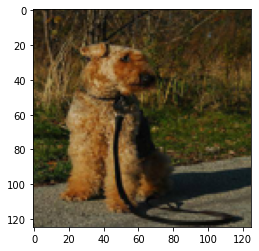

In [10]:
# This is a sample image 
sample=train[5000,:,:,:]
plt.imshow(sample)
plt.show()

In [11]:
# This block of code filters all the other dog beeds out.
# main_labels is the list which contains the name of the given breeds
labels_raw=pd.read_csv(BytesIO(archive_data.read('labels.csv')),header=0, sep=',', quotechar='"')
labels_raw_np=labels_raw["breed"].to_numpy()
labels_raw_np = labels_raw_np.reshape(labels_raw_np.shape[0],1)
main_labels=['beagle','chihuahua','doberman','french_bulldog','golden_retriever','malamute','pug','saint_bernard','scottish_deerhound','tibetan_mastiff']
labels_filtered_index = np.where(labels_raw_np == main_labels)

In [12]:
# These numpy arrays contain the train data and labels only for the given breeds
labels_filtered = labels_raw.iloc[labels_filtered_index[0],:]
train_filtered = train[labels_filtered_index[0],:,:,:]

In [13]:
labels_filtered[:5]

,id,breed
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
20,008b1271ed1addaccf93783b39deab45,doberman
25,00a366d4b4a9bbb6c8a63126697b7656,golden_retriever
37,0100f55e4f0fe28f2c0465d3fc4b9897,golden_retriever


In [15]:
# Shape(1,125,125,3)
train_filtered[1]

array([[[0.02745098, 0.03137255, 0.        ],
        [0.03921569, 0.04313725, 0.00784314],
        [0.06666667, 0.07058824, 0.03921569],
        ...,
        [0.23137255, 0.2627451 , 0.11372549],
        [0.34509804, 0.4       , 0.09803922],
        [0.35686275, 0.4       , 0.14901961]],

       [[0.02352941, 0.02745098, 0.        ],
        [0.01960784, 0.02352941, 0.        ],
        [0.02352941, 0.02745098, 0.00392157],
        ...,
        [0.20784314, 0.24313725, 0.08627451],
        [0.33333333, 0.38431373, 0.10980392],
        [0.36078431, 0.39607843, 0.13333333]],

       [[0.02745098, 0.03137255, 0.00784314],
        [0.01960784, 0.02352941, 0.00392157],
        [0.02352941, 0.03137255, 0.00784314],
        ...,
        [0.14117647, 0.17254902, 0.02352941],
        [0.25882353, 0.29803922, 0.0745098 ],
        [0.34117647, 0.37254902, 0.09803922]],

       ...,

       [[0.16078431, 0.24313725, 0.08235294],
        [0.1372549 , 0.21568627, 0.06666667],
        [0.1254902 , 0

In [16]:
#Reshaping the arrays for further processing
labels=labels_filtered["breed"].to_numpy()
labels = labels.reshape(labels.shape[0],1)
labels.shape


(841, 1)

In [18]:
labels[:5] #labels of first 5 dogs

array([['golden_retriever'],
       ['scottish_deerhound'],
       ['doberman'],
       ['golden_retriever'],
       ['golden_retriever']], dtype=object)

In [19]:
# This method is used to perform one hot encoding of the labels
def matrix_Bin(labels):
    labels_bin=np.array([])

    labels_name, labels0 = np.unique(labels, return_inverse=True)
    labels0
    
    for _, i in enumerate(itemfreq(labels0)[:,0].astype(int)):
        labels_bin0 = np.where(labels0 == itemfreq(labels0)[:,0][i], 1., 0.)
        labels_bin0 = labels_bin0.reshape(1,labels_bin0.shape[0])

        if (labels_bin.shape[0] == 0):
            labels_bin = labels_bin0
        else:
            labels_bin = np.concatenate((labels_bin,labels_bin0 ),axis=0)

    print("Nber SubVariables {0}".format(itemfreq(labels0)[:,0].shape[0]))
    labels_bin = labels_bin.transpose()
    print("Shape : {0}".format(labels_bin.shape))
    
    return labels_name, labels_bin

In [ ]:
# labels_name contains the names of the breeds while the labels_bin contains the numeric values
labels_name, labels_bin = matrix_Bin(labels = labels)

In [21]:
labels_cls = np.argmax(labels_bin, axis=1)
labels_cls[:5]  # Numeric repr of labels of first 5 dogs

array([4, 8, 2, 4, 4])

In [22]:
labels_bin[:5]

array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [24]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model without the top layer
ResNet50_model = ResNet50(weights='imagenet',include_top=False,input_shape=(125,125,3))

In [25]:
# Adding 3 layers to the above model
avg2dpooling=AveragePooling2D(pool_size=(2,2))(ResNet50_model.layers[-1].output)
flat=Flatten()(avg2dpooling)
output=Dense(10,activation='softmax')(flat)
model=Model(inputs=ResNet50_model.inputs,outputs=output)

In [26]:
# This is to make sure that only last 3 layers should be trainable
for layer in model.layers[:-3]:
  layer.trainable=False

In [27]:
#compile the model
model.compile(loss='categorical_crossentropy',optimizer='rmsprop', metrics=['accuracy'])

In [28]:
from keras.utils import to_categorical
model.fit(train_filtered,to_categorical(labels_cls),batch_size=32,epochs=500,validation_split=0.2)

Epoch 1/500
21/21 [==============================] - 12s 102ms/step - loss: 2.4513 - accuracy: 0.1220 - val_loss: 2.2517 - val_accuracy: 0.2012
Epoch 2/500
21/21 [==============================] - 1s 43ms/step - loss: 2.2776 - accuracy: 0.1559 - val_loss: 2.2245 - val_accuracy: 0.1598
Epoch 3/500
21/21 [==============================] - 1s 43ms/step - loss: 2.2130 - accuracy: 0.2172 - val_loss: 2.2363 - val_accuracy: 0.2071
Epoch 4/500
21/21 [==============================] - 1s 43ms/step - loss: 2.2243 - accuracy: 0.1750 - val_loss: 2.2094 - val_accuracy: 0.2249
Epoch 5/500
21/21 [==============================] - 1s 43ms/step - loss: 2.1761 - accuracy: 0.2344 - val_loss: 2.1673 - val_accuracy: 0.2071
Epoch 6/500
21/21 [==============================] - 1s 43ms/step - loss: 2.1453 - accuracy: 0.2269 - val_loss: 2.1876 - val_accuracy: 0.2426
Epoch 7/500
21/21 [==============================] - 1s 42ms/step - loss: 2.1307 - accuracy: 0.2659 - val_loss: 2.2281 - val_accuracy: 0.2012
Epoc

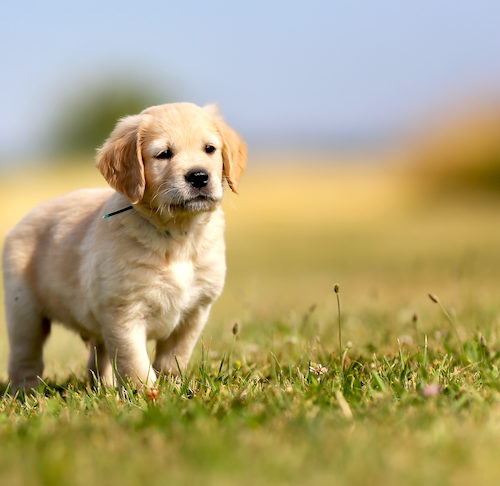

(1, 125, 125, 3)

In [53]:
image=PIL.Image.open('gd1.jpg')
display(image)
image = image.resize((125, 125))
image = np.array(image)
image = np.clip(image/255.0, 0.0, 1.0)
image=np.expand_dims(image,axis=0)
image.shape

In [57]:
l=model.predict(image)

In [58]:
labels[np.argmax(i)][0]

'golden_retriever'